## EENG 439: Neural Networks and Learning Systems Final Project

### Corn Future Predictions using Convolutional Neural Networks

In [414]:
# Install Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime, timedelta
import pickle
from functools import reduce

In [415]:
## Load in the data
corn_files = ['USDAProj_Corn_2017to2018.csv',
'USDAProj_Corn_2016to2017.csv',
'USDAProj_Corn_2015to2016.csv',
'USDAProj_Corn_2009to2010.csv',
'USDAProj_Corn_2014to2015.csv',
'USDAProj_Corn_2013to2014.csv',
'USDAProj_Corn_2012to2013.csv',
'USDAProj_Corn_2011to2012.csv',
'USDAProj_Corn_2010to2011.csv',
'USDAProj_Corn_2008to2009.csv',
'USDAProj_Corn_2007to2008.csv']

soybeans_files = ['USDAProj_Soybean_2017to2018.csv',
'USDAProj_Soybean_2016to2017.csv',
'USDAProj_Soybean_2015to2016.csv',
'USDAProj_Soybean_2009to2010.csv',
'USDAProj_Soybean_2014to2015.csv',
'USDAProj_Soybean_2013to2014.csv',
'USDAProj_Soybean_2012to2013.csv',
'USDAProj_Soybean_2011to2012.csv',
'USDAProj_Soybean_2010to2011.csv',
'USDAProj_Soybean_2008to2009.csv',
'USDAProj_Soybean_2007to2008.csv']

corn_files.sort()
soybeans_files.sort()

monthly_corn_data = pd.read_csv('Data/USDAProj_Corn_2007to2008.csv')
for file in corn_files[1:]:
    file_path = str('Data/' + file)
    monthly_corn_data = monthly_corn_data.append(pd.read_csv(file_path))
monthly_corn_data.sort_values(by="Date")
    
corn_prices = pd.read_csv('Data/Corn_prices.csv')
corn_prices_new = pd.read_csv('Data/corn_prices_edited.csv')

monthly_soybean_data = pd.read_csv('Data/USDAProj_Soybean_2007to2008.csv')
for file in soybeans_files[1:]:
    file_path = str('Data/' + file)
    monthly_soybean_data = monthly_soybean_data.append(pd.read_csv(file_path))
    
monthly_soybean_data.sort_values(by="Date")
    
soybean_prices = pd.read_csv('Data/Soybean_prices.csv')

weather = pd.read_csv('Data/weather_data_iowa.csv')

In [416]:
weather

,STATION,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,TMAX,TMIN,WDMV,WSF2,WSF5
0,USW00014933,41.53380,-93.65300,291.7,2004-01-01,0.00,52.0,27.0,NaN,21.0,23.0
1,USW00014933,41.53380,-93.65300,291.7,2004-01-02,0.00,60.0,31.0,NaN,21.0,25.9
2,USW00014933,41.53380,-93.65300,291.7,2004-01-03,0.00,34.0,20.0,NaN,19.9,21.9
3,USW00014933,41.53380,-93.65300,291.7,2004-01-04,0.30,21.0,11.0,NaN,21.9,29.1
4,USW00014933,41.53380,-93.65300,291.7,2004-01-05,0.00,11.0,-5.0,NaN,23.9,29.1
...,...,...,...,...,...,...,...,...,...,...,...
23353,USW00094988,42.11056,-92.91611,296.9,2019-12-27,0.00,40.0,21.0,NaN,18.1,23.0
23354,USW00094988,42.11056,-92.91611,296.9,2019-12-28,0.84,49.0,31.0,NaN,21.9,27.1
23355,USW00094988,42.11056,-92.91611,296.9,2019-12-29,0.01,52.0,30.0,NaN,23.9,35.1
23356,USW00094988,42.11056,-92.91611,296.9,2019-12-30,0.00,30.0,22.0,NaN,28.0,40.0


In [417]:
#check shapes
print(monthly_corn_data.shape)
print(monthly_soybean_data.shape)

print(corn_prices.shape)
print(soybean_prices.shape)

(248, 113)
(248, 70)
(1035, 8)
(942, 8)


In [418]:
monthly_corn_data

,Date,Area Planted,Area Harvested,Yield,Beginning Stocks,Production,Imports,Total Supply,Feed and Residual,FSI,...,Southeast Asia DomesticTotal,Southeast Asia Exports,Southeast Asia EndingStocks,European Union BeginningStocks,European Union Production,European Union Imports,European Union DomesticFeed,European Union DomesticTotal,European Union Exports,European Union EndingStocks
0,2007/05/11,90.5,82.9,150.3,937.0,12460.0,15.0,13412.0,5700.0,4790.0,...,21.35,0.24,1.95,10.42,55.37,3.5,45.3,60.3,0.3,8.69
1,2007/06/11,90.5,82.9,150.3,987.0,12460.0,15.0,13462.0,5700.0,4790.0,...,21.35,0.24,1.95,10.72,55.72,3.5,45.8,60.8,0.3,8.84
2,2007/07/12,92.9,85.4,150.3,1137.0,12840.0,15.0,13992.0,5700.0,4790.0,...,21.35,0.24,1.97,10.72,55.23,3.5,45.8,60.8,0.3,8.35
3,2007/08/10,92.9,85.4,152.8,1137.0,13054.0,15.0,14206.0,5750.0,4790.0,...,21.35,0.24,1.92,10.72,48.43,6.0,45.8,60.8,0.3,4.05
4,2007/09/12,92.9,85.4,155.8,1142.0,13308.0,15.0,14465.0,5850.0,4690.0,...,21.35,0.24,1.77,10.62,46.94,8.0,46.5,61.5,0.3,3.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,2017/11/09,90.4,83.1,175.4,2295.0,14578.0,50.0,16922.0,5575.0,6935.0,...,43.70,0.72,2.67,7.09,59.59,16.0,56.0,74.7,1.5,6.47
7,2017/12/12,90.4,83.1,175.4,2295.0,14578.0,50.0,16922.0,5575.0,6985.0,...,43.70,0.72,2.77,7.55,60.09,16.0,56.0,74.8,2.0,6.84
8,2018/01/12,90.2,82.7,176.6,2293.0,14604.0,50.0,16947.0,5550.0,6995.0,...,43.70,0.82,2.75,7.54,60.09,16.0,56.0,74.8,2.0,6.83
9,2018/02/08,90.2,82.7,176.6,2293.0,14604.0,50.0,16947.0,5550.0,6995.0,...,43.80,0.82,2.73,7.54,60.09,16.2,56.2,75.0,2.0,6.83


In [419]:
#no NA rows
len(monthly_corn_data[monthly_corn_data.isna().any(axis=1)]) == 0
len(monthly_soybean_data[monthly_soybean_data.isna().any(axis=1)]) == 0
len(corn_prices[corn_prices.isna().any(axis=1)]) == 0
len(soybean_prices[soybean_prices.isna().any(axis=1)]) == 0

True

In [420]:
#normalize the prices data
normalized_monthly_corn_data=(monthly_corn_data.iloc[:,1:]-monthly_corn_data.iloc[:,1:].min())
normalized_monthly_corn_data = normalized_monthly_corn_data/normalized_monthly_corn_data.max()
#normalized_monthly_corn_data.drop_duplicates().reset_index(drop=True)
#insert the data back in
normalized_monthly_corn_data.insert(0, 'Date', monthly_corn_data['Date'])#.drop_duplicates().reset_index(drop=True))
#sort values
normalized_monthly_corn_data = normalized_monthly_corn_data.sort_values(by='Date').reset_index(drop=True)

In [421]:
normalized_monthly_corn_data

,Date,Area Planted,Area Harvested,Yield,Beginning Stocks,Production,Imports,Total Supply,Feed and Residual,FSI,...,Southeast Asia DomesticTotal,Southeast Asia Exports,Southeast Asia EndingStocks,European Union BeginningStocks,European Union Production,European Union Imports,European Union DomesticFeed,European Union DomesticTotal,European Union Exports,European Union EndingStocks
0,2007/05/11,0.443548,0.435897,0.518315,0.161498,0.388053,0.044586,0.313310,0.783133,0.180000,...,0.016529,0.104167,0.180791,0.959405,0.305442,0.105634,0.127778,0.104545,0.000000,0.824859
1,2007/06/11,0.443548,0.435897,0.518315,0.190755,0.388053,0.044586,0.322845,0.783133,0.180000,...,0.016529,0.104167,0.180791,1.000000,0.317347,0.105634,0.155556,0.127273,0.000000,0.846045
2,2007/07/12,0.637097,0.649573,0.518315,0.278525,0.472124,0.044586,0.423913,0.783133,0.180000,...,0.016529,0.104167,0.186441,1.000000,0.300680,0.105634,0.155556,0.127273,0.000000,0.776836
3,2007/08/10,0.637097,0.649573,0.564103,0.278525,0.519469,0.044586,0.464722,0.807229,0.180000,...,0.016529,0.104167,0.172316,1.000000,0.069388,0.281690,0.155556,0.127273,0.000000,0.169492
4,2007/09/12,0.637097,0.649573,0.619048,0.281451,0.575664,0.044586,0.514111,0.855422,0.143636,...,0.016529,0.104167,0.129944,0.986468,0.018707,0.422535,0.194444,0.159091,0.000000,0.128531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,2018/01/12,0.419355,0.418803,1.000000,0.954944,0.862389,0.267516,0.987414,0.710843,0.981818,...,0.940083,0.506944,0.406780,0.569689,0.465986,0.985915,0.722222,0.763636,0.455764,0.562147
244,2018/02/08,0.419355,0.418803,1.000000,0.954944,0.862389,0.267516,0.987414,0.710843,0.981818,...,0.944215,0.506944,0.401130,0.569689,0.465986,1.000000,0.733333,0.772727,0.455764,0.562147
245,2018/02/08,0.725806,0.760684,0.963370,0.629608,0.982743,0.312102,0.986461,0.670843,0.943273,...,0.898760,0.819444,0.525424,0.458728,0.512245,0.932394,0.666667,0.713636,0.501340,0.662429
246,2018/03/08,0.725806,0.760684,0.963370,0.629608,0.982743,0.312102,0.986461,0.673735,0.940727,...,0.898760,0.819444,0.525424,0.458728,0.512245,0.932394,0.666667,0.713636,0.501340,0.662429


In [422]:
to_delete = []
#get rid of the duplicate reports because there are two of each from overlapping years
for i in range(1,len(normalized_monthly_corn_data)):
    if normalized_monthly_corn_data['Date'][i] == normalized_monthly_corn_data['Date'][i-1]:
        to_delete.append(i)

In [423]:
#drops the rows to delete and resets index
normalized_monthly_corn_data = normalized_monthly_corn_data.drop(to_delete).reset_index(drop=True)

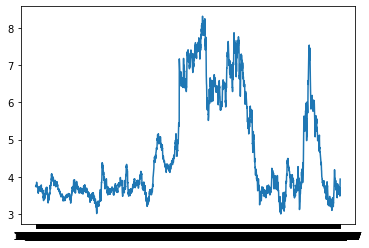

In [424]:
corn_prices_new = corn_prices_new[corn_prices_new['Close'] != 0]
plt.plot(corn_prices_new['Date'], corn_prices_new['Close'])

In [425]:
#convert the dates to datetime
corn_prices['dates'] = pd.to_datetime(corn_prices['dates'])
normalized_monthly_corn_data['Date'] = pd.to_datetime(normalized_monthly_corn_data['Date'])

In [426]:
normalized_monthly_corn_data

,Date,Area Planted,Area Harvested,Yield,Beginning Stocks,Production,Imports,Total Supply,Feed and Residual,FSI,...,Southeast Asia DomesticTotal,Southeast Asia Exports,Southeast Asia EndingStocks,European Union BeginningStocks,European Union Production,European Union Imports,European Union DomesticFeed,European Union DomesticTotal,European Union Exports,European Union EndingStocks
0,2007-05-11,0.443548,0.435897,0.518315,0.161498,0.388053,0.044586,0.313310,0.783133,0.180000,...,0.016529,0.104167,0.180791,0.959405,0.305442,0.105634,0.127778,0.104545,0.000000,0.824859
1,2007-06-11,0.443548,0.435897,0.518315,0.190755,0.388053,0.044586,0.322845,0.783133,0.180000,...,0.016529,0.104167,0.180791,1.000000,0.317347,0.105634,0.155556,0.127273,0.000000,0.846045
2,2007-07-12,0.637097,0.649573,0.518315,0.278525,0.472124,0.044586,0.423913,0.783133,0.180000,...,0.016529,0.104167,0.186441,1.000000,0.300680,0.105634,0.155556,0.127273,0.000000,0.776836
3,2007-08-10,0.637097,0.649573,0.564103,0.278525,0.519469,0.044586,0.464722,0.807229,0.180000,...,0.016529,0.104167,0.172316,1.000000,0.069388,0.281690,0.155556,0.127273,0.000000,0.169492
4,2007-09-12,0.637097,0.649573,0.619048,0.281451,0.575664,0.044586,0.514111,0.855422,0.143636,...,0.016529,0.104167,0.129944,0.986468,0.018707,0.422535,0.194444,0.159091,0.000000,0.128531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,2017-11-09,0.725806,0.760684,0.963370,0.629608,0.982743,0.312102,0.986461,0.668916,0.944000,...,0.898760,0.819444,0.488701,0.454668,0.500340,0.901408,0.661111,0.704545,0.455764,0.598870
126,2017-12-12,0.725806,0.760684,0.963370,0.629608,0.982743,0.312102,0.986461,0.668916,0.944000,...,0.898760,0.819444,0.516949,0.458728,0.512245,0.933099,0.666667,0.713636,0.501340,0.663842
127,2018-01-12,0.725806,0.760684,0.963370,0.629608,0.982743,0.312102,0.986461,0.670843,0.943273,...,0.898760,0.819444,0.528249,0.458728,0.512245,0.932394,0.666667,0.713636,0.501340,0.662429
128,2018-02-08,0.419355,0.418803,1.000000,0.954944,0.862389,0.267516,0.987414,0.710843,0.981818,...,0.944215,0.506944,0.401130,0.569689,0.465986,1.000000,0.733333,0.772727,0.455764,0.562147


In [427]:
price_years = []
for i in range(len(corn_prices['dates'])):
    price_years.append(corn_prices['dates'][i].year)
    
price_years = np.unique(price_years)

In [428]:
data_years = []
for i in range(len(normalized_monthly_corn_data['Date'])):
    data_years.append(normalized_monthly_corn_data['Date'][i].year)
    
data_years = np.unique(data_years)

In [429]:
#years to get
data_years

array([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018])

In [430]:
#finds how many days are missing between each report
to_add = []
for i in range(len(normalized_monthly_corn_data)-1):
    if (normalized_monthly_corn_data['Date'][i+1] - normalized_monthly_corn_data['Date'][i]).days > 0: 
        to_add.append((normalized_monthly_corn_data['Date'][i+1] - normalized_monthly_corn_data['Date'][i]).days)
    else:
        to_add.append(365 - (normalized_monthly_corn_data['Date'][i] - normalized_monthly_corn_data['Date'][i+1]).days)
to_add.append(30)

In [431]:
np.mean(to_add)

30.646153846153847

In [432]:
number = 0
for add in to_add:
    number += add
number

3984

In [433]:
#repeats the rows of data
normalized_monthly_corn_data = normalized_monthly_corn_data.loc[normalized_monthly_corn_data.index.repeat(to_add)].reset_index(drop=True)

In [434]:
#writes over for the correct dates
for i in range(1,len(normalized_monthly_corn_data)):
    normalized_monthly_corn_data['Date'][i] = normalized_monthly_corn_data['Date'][i-1]+timedelta(days=1)
normalized_monthly_corn_data

<ipython-input-434-7a1f060d88e2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normalized_monthly_corn_data['Date'][i] = normalized_monthly_corn_data['Date'][i-1]+timedelta(days=1)


,Date,Area Planted,Area Harvested,Yield,Beginning Stocks,Production,Imports,Total Supply,Feed and Residual,FSI,...,Southeast Asia DomesticTotal,Southeast Asia Exports,Southeast Asia EndingStocks,European Union BeginningStocks,European Union Production,European Union Imports,European Union DomesticFeed,European Union DomesticTotal,European Union Exports,European Union EndingStocks
0,2007-05-11,0.443548,0.435897,0.518315,0.161498,0.388053,0.044586,0.313310,0.783133,0.180000,...,0.016529,0.104167,0.180791,0.959405,0.305442,0.105634,0.127778,0.104545,0.00000,0.824859
1,2007-05-12,0.443548,0.435897,0.518315,0.161498,0.388053,0.044586,0.313310,0.783133,0.180000,...,0.016529,0.104167,0.180791,0.959405,0.305442,0.105634,0.127778,0.104545,0.00000,0.824859
2,2007-05-13,0.443548,0.435897,0.518315,0.161498,0.388053,0.044586,0.313310,0.783133,0.180000,...,0.016529,0.104167,0.180791,0.959405,0.305442,0.105634,0.127778,0.104545,0.00000,0.824859
3,2007-05-14,0.443548,0.435897,0.518315,0.161498,0.388053,0.044586,0.313310,0.783133,0.180000,...,0.016529,0.104167,0.180791,0.959405,0.305442,0.105634,0.127778,0.104545,0.00000,0.824859
4,2007-05-15,0.443548,0.435897,0.518315,0.161498,0.388053,0.044586,0.313310,0.783133,0.180000,...,0.016529,0.104167,0.180791,0.959405,0.305442,0.105634,0.127778,0.104545,0.00000,0.824859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3979,2018-04-02,0.725806,0.760684,0.963370,0.629608,0.982743,0.312102,0.986461,0.673735,0.940727,...,0.898760,0.819444,0.525424,0.458728,0.512245,0.932394,0.666667,0.713636,0.50134,0.662429
3980,2018-04-03,0.725806,0.760684,0.963370,0.629608,0.982743,0.312102,0.986461,0.673735,0.940727,...,0.898760,0.819444,0.525424,0.458728,0.512245,0.932394,0.666667,0.713636,0.50134,0.662429
3981,2018-04-04,0.725806,0.760684,0.963370,0.629608,0.982743,0.312102,0.986461,0.673735,0.940727,...,0.898760,0.819444,0.525424,0.458728,0.512245,0.932394,0.666667,0.713636,0.50134,0.662429
3982,2018-04-05,0.725806,0.760684,0.963370,0.629608,0.982743,0.312102,0.986461,0.673735,0.940727,...,0.898760,0.819444,0.525424,0.458728,0.512245,0.932394,0.666667,0.713636,0.50134,0.662429


In [435]:
corn_prices_new['Date'] = pd.to_datetime(corn_prices_new['Date'])

In [437]:
corn_prices_new

,Open,Close,High,Low,Volume,Date
0,3.7550,3.7500,3.7700,3.7275,NaN,2018-12-31
1,3.7450,3.7550,3.7750,3.7450,NaN,2018-12-28
2,3.7325,3.7450,3.7650,3.7325,NaN,2018-12-27
3,3.7825,3.7325,3.7925,3.7250,NaN,2018-12-26
4,3.7825,3.7775,3.7900,3.7525,NaN,2018-12-24
...,...,...,...,...,...,...
2952,3.5975,3.6025,3.6100,3.5875,NaN,2007-04-04
2953,3.4700,3.4850,3.5000,3.4700,NaN,2007-04-03
2954,3.5600,3.5700,3.5725,3.5500,NaN,2007-04-02
2955,0.0000,3.7450,3.9775,3.7400,NaN,2007-03-30


In [438]:
#normalize the prices
corn_prices_new1 = (corn_prices_new.iloc[:,:-1]-corn_prices_new.iloc[:,:-1].min())
corn_prices_new1 = corn_prices_new1/ corn_prices_new1.max()
corn_prices_new1['Date'] = corn_prices_new['Date']
temp = corn_prices_new
corn_prices_new = corn_prices_new1
corn_prices_new1 = temp

In [314]:
#normalize the weather
weather['Date'] = pd.to_datetime(weather['DATE'])
weather_subset = weather[weather['STATION'] == 'USW00014933']
weather_subset = weather_subset[list(weather_subset.columns[-7:])]

weather_subset1 = (weather_subset.iloc[:,:-1]-weather_subset.iloc[:,:-1].min())
weather_subset1 = weather_subset1 / weather_subset1.max()
weather_subset1['Date'] = weather_subset['Date']
weather_subset = weather_subset1
weather_subset['PRCP']

0       0.000000
1       0.000000
2       0.000000
3       0.066225
4       0.000000
          ...   
5839    0.000000
5840    0.185430
5841    0.000000
5842    0.000000
5843    0.000000
Name: PRCP, Length: 5844, dtype: float64

In [315]:
#merge the data
full_data = corn_prices_new.merge(weather_subset, how = 'left', on = 'Date' )
full_data = full_data.merge(normalized_monthly_corn_data, how = 'left', on = 'Date' )
full_data 

,Open,Close,High,Low,Volume,Date,PRCP,TMAX,TMIN,WDMV,...,Southeast Asia DomesticTotal,Southeast Asia Exports,Southeast Asia EndingStocks,European Union BeginningStocks,European Union Production,European Union Imports,European Union DomesticFeed,European Union DomesticTotal,European Union Exports,European Union EndingStocks
0,0.452273,0.140367,0.446815,0.453054,NaN,2018-12-31,0.024283,0.371681,0.396040,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.451069,0.141309,0.447407,0.455181,NaN,2018-12-28,0.002208,0.309735,0.326733,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.449563,0.139425,0.446222,0.453662,NaN,2018-12-27,0.198675,0.539823,0.475248,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.455586,0.137070,0.449481,0.452750,NaN,2018-12-26,0.121413,0.424779,0.495050,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.455586,0.145549,0.449185,0.456092,NaN,2018-12-24,0.000000,0.380531,0.386139,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2929,0.433303,0.112577,0.427852,0.436038,NaN,2007-04-04,0.000000,0.389381,0.396040,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2930,0.417946,0.090438,0.414815,0.421756,NaN,2007-04-03,0.070640,0.522124,0.445545,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2931,0.428787,0.106453,0.423407,0.431480,NaN,2007-04-02,0.000000,0.610619,0.594059,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2932,0.000000,0.139425,0.471407,0.454573,NaN,2007-03-30,0.048565,0.699115,0.742574,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [316]:
#take the subset of meaningful fields
subset = full_data[['Date', 'Close', 'High', 'Low','PRCP',
 'TMAX',
 'TMIN',
 'WSF2',
 'WSF5','Area Planted',
 'Area Harvested',
 'Yield',
 'Beginning Stocks',
 'Production',
 'Imports',
 'Total Supply',
 'Feed and Residual',
 'FSI',
 'Ethanol',
 'Total Domestic',
 'Exports',
 'Total Use']]

#drop zeros
subset = subset[subset['Close']!= -3.204636436946188].sort_values(by='Date', ascending = True).reset_index(drop=True)

#generates the time lags
def generate_time_lags(df,col, n_lags):
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"lag{n, col}"] = df_n[col].shift(n)
    #df_n = df_n.iloc[n_lags:]
    
    
    return df_n


df_generated = subset

#calls the lag function on the subset
for column in list(df_generated.keys())[1:]:
    df_generated = generate_time_lags(df_generated, column, 20)
df_generated


,Date,Close,High,Low,PRCP,TMAX,TMIN,WSF2,WSF5,Area Planted,...,"lag(11, 'Total Use')","lag(12, 'Total Use')","lag(13, 'Total Use')","lag(14, 'Total Use')","lag(15, 'Total Use')","lag(16, 'Total Use')","lag(17, 'Total Use')","lag(18, 'Total Use')","lag(19, 'Total Use')","lag(20, 'Total Use')"
0,2007-03-29,0.176166,0.467259,0.477059,0.002208,0.575221,0.712871,0.100749,0.119390,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2007-03-30,0.139425,0.471407,0.454573,0.048565,0.699115,0.742574,0.084097,0.110076,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2007-04-02,0.106453,0.423407,0.431480,0.000000,0.610619,0.594059,0.108243,0.127011,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2007-04-03,0.090438,0.414815,0.421756,0.070640,0.522124,0.445545,0.266445,0.314987,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2007-04-04,0.112577,0.427852,0.436038,0.000000,0.389381,0.396040,0.225645,0.280271,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2929,2018-12-24,0.145549,0.449185,0.456092,0.000000,0.380531,0.386139,0.067444,0.085521,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2930,2018-12-26,0.137070,0.449481,0.452750,0.121413,0.424779,0.495050,0.109908,0.195597,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2931,2018-12-27,0.139425,0.446222,0.453662,0.198675,0.539823,0.475248,0.218152,0.280271,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2932,2018-12-28,0.141309,0.447407,0.455181,0.002208,0.309735,0.326733,0.168193,0.238781,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [317]:
subset

,Date,Close,High,Low,PRCP,TMAX,TMIN,WSF2,WSF5,Area Planted,...,Beginning Stocks,Production,Imports,Total Supply,Feed and Residual,FSI,Ethanol,Total Domestic,Exports,Total Use
0,2007-03-29,0.176166,0.467259,0.477059,0.002208,0.575221,0.712871,0.100749,0.119390,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2007-03-30,0.139425,0.471407,0.454573,0.048565,0.699115,0.742574,0.084097,0.110076,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2007-04-02,0.106453,0.423407,0.431480,0.000000,0.610619,0.594059,0.108243,0.127011,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2007-04-03,0.090438,0.414815,0.421756,0.070640,0.522124,0.445545,0.266445,0.314987,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2007-04-04,0.112577,0.427852,0.436038,0.000000,0.389381,0.396040,0.225645,0.280271,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2929,2018-12-24,0.145549,0.449185,0.456092,0.000000,0.380531,0.386139,0.067444,0.085521,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2930,2018-12-26,0.137070,0.449481,0.452750,0.121413,0.424779,0.495050,0.109908,0.195597,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2931,2018-12-27,0.139425,0.446222,0.453662,0.198675,0.539823,0.475248,0.218152,0.280271,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2932,2018-12-28,0.141309,0.447407,0.455181,0.002208,0.309735,0.326733,0.168193,0.238781,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [318]:
#create a list of matrices
subset_matrices = []
for i in range(len(subset)):
    subset_matrices.append(subset.iloc[i-22:i,0:23])


In [319]:
subset_matrices[22].isnull().values.any()

True

In [320]:
#create the dict of matrices
matrices_dict = {}
i = 0
for year in data_years:
    
    days_since_harvest = 0
    
    matrices_dict[year] = []
    
    while subset_matrices[i+22]['Date'][i].month != 10 or subset_matrices[i+22]['Date'][i].year != year:

    #for i in range(len(corn_prices_new)):
        #if corn_prices_new['Date'][i].year == year:
            #add the days since harvest
            subset_matrices[i+1]['Days Since Harvest'] = [x for x in range(days_since_harvest-21, days_since_harvest+1)]
            matrices_dict[year].append(subset_matrices[i+1])
            i = i + 1
            days_since_harvest = days_since_harvest +1

In [321]:
subset_matrices[1000]

,Date,Close,High,Low,PRCP,TMAX,TMIN,WSF2,WSF5,Area Planted,...,Production,Imports,Total Supply,Feed and Residual,FSI,Ethanol,Total Domestic,Exports,Total Use,Days Since Harvest
978,2011-04-07,0.863872,0.916444,0.914919,0.269316,0.566372,0.643564,0.108243,0.127011,0.112903,...,0.527876,0.000000,0.573036,0.513253,0.597818,0.616381,0.432210,0.715000,0.527478,136
979,2011-04-08,0.880829,0.911704,0.913096,0.000000,0.548673,0.683168,0.084097,0.119390,0.258065,...,0.385177,0.076433,0.458810,0.518072,0.765455,0.780952,0.608614,0.694444,0.644397,137
980,2011-04-11,0.895902,0.928889,0.923731,0.000000,0.654867,0.633663,0.168193,0.204911,0.258065,...,0.385177,0.076433,0.458810,0.518072,0.765455,0.780952,0.608614,0.694444,0.644397,138
981,2011-04-12,0.851625,0.919111,0.907627,0.000000,0.681416,0.603960,0.059950,0.127011,0.258065,...,0.385177,0.076433,0.458810,0.518072,0.765455,0.780952,0.608614,0.694444,0.644397,139
982,2011-04-13,0.857277,0.910815,0.907323,0.000000,0.725664,0.702970,0.192340,0.221846,0.258065,...,0.385177,0.076433,0.458810,0.518072,0.765455,0.780952,0.608614,0.694444,0.644397,140
983,2011-04-14,0.854922,0.901037,0.900942,0.041943,0.619469,0.653465,0.201499,0.270957,0.258065,...,0.385177,0.076433,0.458810,0.518072,0.765455,0.780952,0.608614,0.694444,0.644397,141
984,2011-04-15,0.831842,0.898667,0.898815,0.203091,0.477876,0.594059,0.201499,0.270957,0.258065,...,0.385177,0.076433,0.458810,0.518072,0.765455,0.780952,0.608614,0.694444,0.644397,142
985,2011-04-18,0.850212,0.892741,0.891826,0.002208,0.469027,0.594059,0.124896,0.154107,0.258065,...,0.385177,0.076433,0.458810,0.518072,0.765455,0.780952,0.608614,0.694444,0.644397,143
986,2011-04-19,0.845031,0.897481,0.908538,0.198675,0.442478,0.544554,0.249792,0.304826,0.258065,...,0.385177,0.076433,0.458810,0.518072,0.765455,0.780952,0.608614,0.694444,0.644397,144
987,2011-04-20,0.814414,0.910222,0.885749,0.000000,0.522124,0.544554,0.124896,0.178662,0.258065,...,0.385177,0.076433,0.458810,0.518072,0.765455,0.780952,0.608614,0.694444,0.644397,145


In [322]:
#normalize the days since harvest
for key in matrices_dict.keys():
    length = [x for x in range(-21, len(matrices_dict[key]))]
    
    for i in range(len(matrices_dict[key])):
        matrices_dict[key][i]['Days Since Harvest'] = (matrices_dict[key][i]['Days Since Harvest'] - np.min(length))
        matrices_dict[key][i]['Days Since Harvest'] = (matrices_dict[key][i]['Days Since Harvest'] / (np.max(length)+21))

In [323]:
matrices_dict[2008][-1]

,Date,Close,High,Low,PRCP,TMAX,TMIN,WSF2,WSF5,Area Planted,...,Production,Imports,Total Supply,Feed and Residual,FSI,Ethanol,Total Domestic,Exports,Total Use,Days Since Harvest
331,2008-08-25,0.527084,0.721481,0.703130,0.000000,0.752212,0.772277,0.076603,NaN,0.693548,...,0.523894,0.063694,0.500953,0.951807,0.018182,0.019048,0.17603,0.958333,0.461207,0.914286
332,2008-08-26,0.517664,0.691259,0.690672,0.000000,0.761062,0.772277,0.093256,0.110076,0.693548,...,0.523894,0.063694,0.500953,0.951807,0.018182,0.019048,0.17603,0.958333,0.461207,0.918367
333,2008-08-27,0.521903,0.693630,0.689456,0.037528,0.752212,0.801980,0.158201,0.187976,0.693548,...,0.523894,0.063694,0.500953,0.951807,0.018182,0.019048,0.17603,0.958333,0.461207,0.922449
334,2008-08-28,0.507772,0.685630,0.685202,0.000000,0.814159,0.841584,0.093256,0.143946,0.693548,...,0.523894,0.063694,0.500953,0.951807,0.018182,0.019048,0.17603,0.958333,0.461207,0.926531
335,2008-09-01,0.504475,0.673481,0.690672,0.000000,0.858407,0.851485,0.124896,0.160881,0.693548,...,0.523894,0.063694,0.500953,0.951807,0.018182,0.019048,0.17603,0.958333,0.461207,0.930612
336,2008-09-02,0.475742,0.664000,0.652081,0.002208,0.840708,0.821782,0.158201,0.178662,0.693548,...,0.523894,0.063694,0.500953,0.951807,0.018182,0.019048,0.17603,0.958333,0.461207,0.934694
337,2008-09-03,0.463495,0.662519,0.649043,0.000000,0.637168,0.742574,0.108243,0.143946,0.693548,...,0.523894,0.063694,0.500953,0.951807,0.018182,0.019048,0.17603,0.958333,0.461207,0.938776
338,2008-09-04,0.468676,0.659556,0.656335,0.116998,0.646018,0.722772,0.093256,0.119390,0.693548,...,0.523894,0.063694,0.500953,0.951807,0.018182,0.019048,0.17603,0.958333,0.461207,0.942857
339,2008-09-08,0.438059,0.642370,0.641750,0.083885,0.592920,0.663366,0.084097,0.110076,0.693548,...,0.523894,0.063694,0.500953,0.951807,0.018182,0.019048,0.17603,0.958333,0.461207,0.946939
340,2008-09-09,0.431465,0.632889,0.627165,0.000000,0.663717,0.633663,0.050791,NaN,0.693548,...,0.523894,0.063694,0.500953,0.951807,0.018182,0.019048,0.17603,0.958333,0.461207,0.951020


In [324]:
#make a dictionary 
def make_year_dict(corn_price):
    price_years_new = []
    for i in range(len(corn_price['Date'])):
        price_years_new.append(corn_price['Date'][i].year)

    price_years_new = np.unique(price_years_new)
    
    to_delete = []
    for i in tqdm(range(len(corn_price))):
        if corn_price['Close'][i] == -3.204636436946188:
            to_delete.append(i)
            
    corn_price = corn_price.drop(to_delete)
    corn_price = corn_price.reset_index(drop=True)
    
    corn_price = corn_price.sort_values(by = 'Date').reset_index(drop=True)
    
    corn_year_dict_new = {}

    i = 0
    for year in price_years_new:
        corn_year_dict_new[year] = pd.DataFrame(columns = corn_price.columns)

        while corn_price['Date'][i].month != 10 or corn_price['Date'][i].year != year:

        #for i in range(len(corn_prices_new)):
            #if corn_prices_new['Date'][i].year == year:
                corn_year_dict_new[year] = corn_year_dict_new[year].append(corn_price.iloc[i,:])
                i = i + 1

        corn_year_dict_new[year] = corn_year_dict_new[year].reset_index(drop=True)
        #plt.plot(corn_year_dict_new[year]['Date'], corn_year_dict_new[year]['Close'])
        #plt.show()
        
    return corn_year_dict_new

In [325]:
#regular data
regular_dict = make_year_dict(full_data)

100%|██████████| 2934/2934 [00:00<00:00, 70448.92it/s]


In [326]:
#lagged data
lagged_dict = make_year_dict(df_generated)

100%|██████████| 2934/2934 [00:00<00:00, 66210.53it/s]


In [327]:
lagged_dict[2008]

,Date,Close,High,Low,PRCP,TMAX,TMIN,WSF2,WSF5,Area Planted,...,"lag(11, 'Total Use')","lag(12, 'Total Use')","lag(13, 'Total Use')","lag(14, 'Total Use')","lag(15, 'Total Use')","lag(16, 'Total Use')","lag(17, 'Total Use')","lag(18, 'Total Use')","lag(19, 'Total Use')","lag(20, 'Total Use')"
0,2007-10-01,0.128592,0.446222,0.447280,0.000000,0.725664,0.772277,0.134055,0.195597,0.637097,...,0.453125,0.453125,0.453125,0.426185,0.426185,0.426185,0.426185,0.426185,0.426185,0.426185
1,2007-10-02,0.090909,0.437037,0.423883,0.302428,0.707965,0.702970,0.234804,0.339543,0.637097,...,0.453125,0.453125,0.453125,0.453125,0.426185,0.426185,0.426185,0.426185,0.426185,0.426185
2,2007-10-03,0.082902,0.416593,0.415983,0.000000,0.716814,0.663366,0.093256,0.110076,0.637097,...,0.453125,0.453125,0.453125,0.453125,0.453125,0.426185,0.426185,0.426185,0.426185,0.426185
3,2007-10-04,0.078662,0.414519,0.414464,0.000000,0.787611,0.732673,0.100749,0.127011,0.637097,...,0.453125,0.453125,0.453125,0.453125,0.453125,0.453125,0.426185,0.426185,0.426185,0.426185
4,2007-10-05,0.078662,0.407407,0.412641,0.000000,0.814159,0.861386,0.174854,0.221846,0.637097,...,0.453125,0.453125,0.453125,0.453125,0.453125,0.453125,0.453125,0.426185,0.426185,0.426185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,2008-09-23,0.489402,0.665778,0.667882,0.008830,0.787611,0.831683,0.134055,0.160881,0.693548,...,0.461207,0.461207,0.461207,0.461207,0.461207,0.461207,0.461207,0.461207,0.461207,0.461207
221,2008-09-24,0.494583,0.680296,0.674567,0.028698,0.761062,0.801980,0.134055,0.143946,0.693548,...,0.461207,0.461207,0.461207,0.461207,0.461207,0.461207,0.461207,0.461207,0.461207,0.461207
222,2008-09-25,0.485634,0.670222,0.674567,0.000000,0.769912,0.762376,0.084097,0.085521,0.693548,...,0.461207,0.461207,0.461207,0.461207,0.461207,0.461207,0.461207,0.461207,0.461207,0.461207
223,2008-09-29,0.400377,0.642667,0.619872,0.145695,0.690265,0.712871,0.174854,0.212532,0.693548,...,0.461207,0.461207,0.461207,0.461207,0.461207,0.461207,0.461207,0.461207,0.461207,0.461207


In [328]:
subset_dict = make_year_dict(subset)

100%|██████████| 2934/2934 [00:00<00:00, 72387.48it/s]


In [329]:
subset_dict[2008]



,Date,Close,High,Low,PRCP,TMAX,TMIN,WSF2,WSF5,Area Planted,...,Beginning Stocks,Production,Imports,Total Supply,Feed and Residual,FSI,Ethanol,Total Domestic,Exports,Total Use
0,2007-10-01,0.128592,0.446222,0.447280,0.000000,0.725664,0.772277,0.134055,0.195597,0.637097,...,0.281451,0.575664,0.044586,0.514111,0.855422,0.143636,0.133333,0.230337,0.861111,0.453125
1,2007-10-02,0.090909,0.437037,0.423883,0.302428,0.707965,0.702970,0.234804,0.339543,0.637097,...,0.281451,0.575664,0.044586,0.514111,0.855422,0.143636,0.133333,0.230337,0.861111,0.453125
2,2007-10-03,0.082902,0.416593,0.415983,0.000000,0.716814,0.663366,0.093256,0.110076,0.637097,...,0.281451,0.575664,0.044586,0.514111,0.855422,0.143636,0.133333,0.230337,0.861111,0.453125
3,2007-10-04,0.078662,0.414519,0.414464,0.000000,0.787611,0.732673,0.100749,0.127011,0.637097,...,0.281451,0.575664,0.044586,0.514111,0.855422,0.143636,0.133333,0.230337,0.861111,0.453125
4,2007-10-05,0.078662,0.407407,0.412641,0.000000,0.814159,0.861386,0.174854,0.221846,0.637097,...,0.281451,0.575664,0.044586,0.514111,0.855422,0.143636,0.133333,0.230337,0.861111,0.453125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,2008-09-23,0.489402,0.665778,0.667882,0.008830,0.787611,0.831683,0.134055,0.160881,0.693548,...,0.376243,0.523894,0.063694,0.500953,0.951807,0.018182,0.019048,0.176030,0.958333,0.461207
221,2008-09-24,0.494583,0.680296,0.674567,0.028698,0.761062,0.801980,0.134055,0.143946,0.693548,...,0.376243,0.523894,0.063694,0.500953,0.951807,0.018182,0.019048,0.176030,0.958333,0.461207
222,2008-09-25,0.485634,0.670222,0.674567,0.000000,0.769912,0.762376,0.084097,0.085521,0.693548,...,0.376243,0.523894,0.063694,0.500953,0.951807,0.018182,0.019048,0.176030,0.958333,0.461207
223,2008-09-29,0.400377,0.642667,0.619872,0.145695,0.690265,0.712871,0.174854,0.212532,0.693548,...,0.376243,0.523894,0.063694,0.500953,0.951807,0.018182,0.019048,0.176030,0.958333,0.461207


In [336]:
corn_close = corn_prices_new[['Date', 'Close']]
corn_close = corn_close.reset_index(drop=True)


close_dict = make_year_dict(corn_close)

100%|██████████| 2934/2934 [00:00<00:00, 76020.29it/s]


In [ ]:
#old labeling
def label(corn_year_dict_new):
    for key in corn_year_dict_new.keys():
        labels = []
        sell_threshold = np.sort(corn_year_dict_new[key]['Close'])[-20]
        buy_threshold = np.sort(corn_year_dict_new[key]['Close'])[20]
        for i in range(len(corn_year_dict_new[key])):
            if corn_year_dict_new[key]['Close'][i] >= sell_threshold:
                labels.append(2)
            elif corn_year_dict_new[key]['Close'][i] <= buy_threshold:
                labels.append(0)
            else:
                labels.append(1)

        corn_year_dict_new[key]['Days Since Harvest'] = (np.array(corn_year_dict_new[key].index) - np.array(corn_year_dict_new[key].index).mean())/np.array(corn_year_dict_new[key].index).std()
        
        corn_year_dict_new[key]['Labels'] = labels

    return corn_year_dict_new

In [376]:
#new labeling
def label_updated(corn_year_dict_new,n):
    for key in corn_year_dict_new.keys():
        labels = []
        
        for i in range(len(corn_year_dict_new[key])):
            
            if i-n<0:
                window = corn_year_dict_new[key]['Close'][0:i+n]
            elif i+10>len(corn_year_dict_new[key]['Close']):
                window = corn_year_dict_new[key]['Close'][i-n:len(corn_year_dict_new[key]['Close'])]
            else:
                window = corn_year_dict_new[key]['Close'][i-n:i+n]
                
            if max(window) == corn_year_dict_new[key]['Close'][i]:
                labels.append(2)
            elif min(window) == corn_year_dict_new[key]['Close'][i]:
                labels.append(0)
            else:
                labels.append(1)

        corn_year_dict_new[key]['Days Since Harvest'] = (np.array(corn_year_dict_new[key].index) - np.array(corn_year_dict_new[key].index).mean())/np.array(corn_year_dict_new[key].index).std()
        
        corn_year_dict_new[key]['Labels'] = labels

    return corn_year_dict_new

In [377]:
#new labeling
def label_updated_2(corn_year_dict_new,m,n):
    for key in corn_year_dict_new.keys():
        labels = []
        sell_threshold = np.sort(corn_year_dict_new[key]['Close'])[-m]
        buy_threshold = np.sort(corn_year_dict_new[key]['Close'])[m]
        
        for i in range(len(corn_year_dict_new[key])):
            
            if i-n<0:
                window = corn_year_dict_new[key]['Close'][0:i+n]
            elif i+10>len(corn_year_dict_new[key]['Close']):
                window = corn_year_dict_new[key]['Close'][i-n:len(corn_year_dict_new[key]['Close'])]
            else:
                window = corn_year_dict_new[key]['Close'][i-n:i+n]
                
            if (max(window) == corn_year_dict_new[key]['Close'][i]) and (corn_year_dict_new[key]['Close'][i] >= sell_threshold):
                labels.append(2)
            elif (min(window) == corn_year_dict_new[key]['Close'][i]) and (corn_year_dict_new[key]['Close'][i] <= buy_threshold):
                labels.append(0)
            else:
                labels.append(1)

        corn_year_dict_new[key]['Days Since Harvest'] = (np.array(corn_year_dict_new[key].index) - np.array(corn_year_dict_new[key].index).mean())/np.array(corn_year_dict_new[key].index).std()
        
        corn_year_dict_new[key]['Labels'] = labels

    return corn_year_dict_new

In [ ]:
labeled_dict = label(regular_dict)
min(labeled_dict[2008]['Labels'])

In [398]:
#create the two dictionaries for lagged data
labeled_dict_lagged = label_updated_2(lagged_dict, 100, 3)

labeled_dict_lagged[2008]

data_lagged = {}
label_lagged = {}
for key in labeled_dict_lagged.keys():
    data_lagged[key] = labeled_dict_lagged[key].iloc[:,:-1]
    label_lagged[key] = labeled_dict_lagged[key].iloc[:,-1]

In [443]:
type(label_lagged[2008])

pandas.core.series.Series

In [400]:
del data_lagged[2018]
del data_lagged[2007]
del label_lagged[2018]
del label_lagged[2007]

In [401]:
#check the labeling
sells = {}
buys = {}
for key in label_lagged.keys():
    sell = []
    buy = []
    for i in range(len(label_lagged[key])):
        if label_lagged[key][i] == 2:
            sell.append(i)
        if label_lagged[key][i] == 0:
            buy.append(i)
    sells[key] = sell
    buys[key] = buy

In [402]:
for key in sells.keys():
    print(len(sells[key]))
    print(len(buys[key]))

16
12
19
16
16
18
19
13
20
20
15
17
20
17
19
23
17
16
19
16


2008


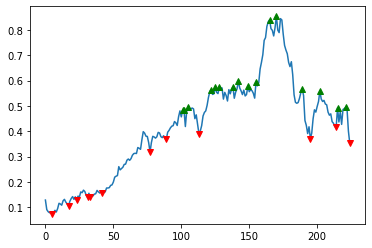

2009


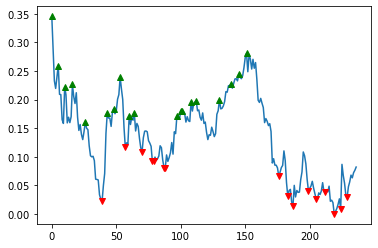

2010


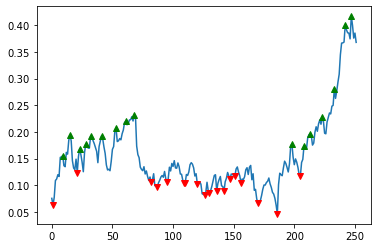

2011


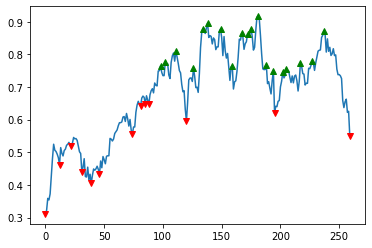

2012


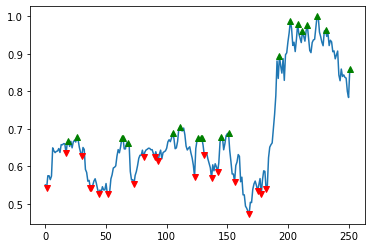

2013


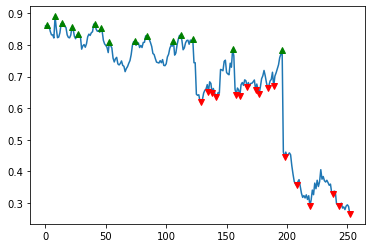

2014


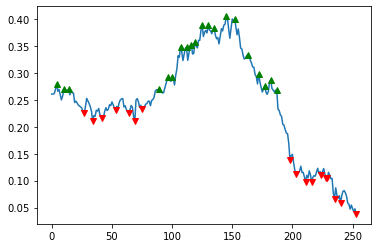

2015


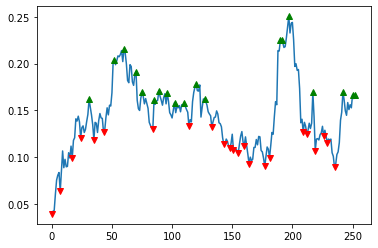

2016


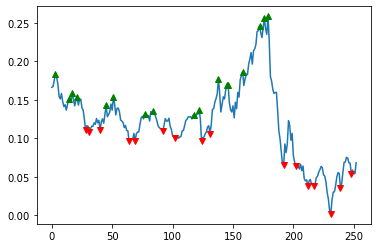

2017


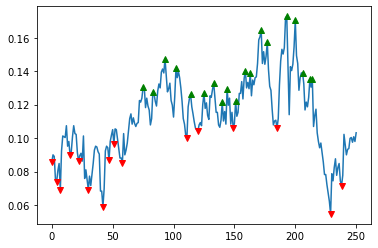

In [403]:
#plot the labeling
for key in data_lagged.keys():
    print(key)
    plt.plot(data_lagged[key]['Close'])
    for sell in sells[key]:
        plt.plot(sell, data_lagged[key]['Close'][sell], marker = '^', color = 'green')
    for buy in buys[key]:
        plt.plot(buy, data_lagged[key]['Close'][buy], marker = 'v', color = 'red')
    plt.show()

In [ ]:
plt.imshow(matrices_dict[2010][0].iloc[:,1:])

In [ ]:
subset_dict_label = label(subset_dict)
subset_dict_label[2008]

In [ ]:
subset_dict_label[2007]

In [ ]:
all_labels_dict = {}
all_data_dict = {}

for key in tqdm(subset_dict_label.keys()):
    labels_list = []
    data_list = []
    for i in range(len(subset_dict_label[key])):
        if i<22:
            data_list.append(subset_dict_label[key].iloc[i-22:i,1:23])
        labels_list.append(subset_dict_label[key]['Labels'][i])
        data_list.append(subset_dict_label[key].iloc[i-22:i,1:23])
        labels_list.append(subset_dict_label[key]['Labels'][i])
    
    all_data_dict[key] = data_list
    all_labels_dict[key] = labels_list
    

In [ ]:
del all_data_dict[2018]
del all_labels_dict[2018]
del all_data_dict[2007]
del all_labels_dict[2007]

In [ ]:
#check NA values
for key in matrices_dict.keys():
    for i in range(len(matrices_dict[key])):
        if matrices_dict[key][i].isnull().values.any() == True:
            print(matrices_dict[key][i])


In [ ]:
#deleted 2007 and 2018
del matrices_dict[2018]
del matrices_dict[2007]

In [ ]:
pd.read_csv('ResNet18-2008.csv')

In [ ]:
for key in matrices_dict.keys():
    file_name = str('ResNet18-' + str(key) + '.csv')
    
    total = reduce(lambda x,y: x.append(y), matrices_dict[key])
    total = total.drop_duplicates().iloc[21:,:]
    total = total.reset_index(drop=True)
    #print(list(total['Days Since Harvest']))
    try:
        sells = list(pd.read_csv(file_name)['Date'])
        print(sells)
   
    except:
        sells = [0]
        
    plt.plot(total['Close'])
    
    sell_days = list(total['Days Since Harvest']).index(float(sell))
    sell_prices = total['Close'][list(total['Days Since Harvest']).index(float(sell))]
    
    for sell in sells:
        sell_days = list(total['Days Since Harvest']).index(float(sell))
        sell_prices = total['Close'][list(total['Days Since Harvest']).index(float(sell))]
        try:
            plt.plot(sell_days, sell_prices, marker = 'o', color = 'orange')
        except:
            pass
    plt.show()

In [ ]:
 -0.204186538351631 == -0.204186538351631

list(total['Days Since Harvest'])[87] == float(sells[0])


list(total['Days Since Harvest'])[0] == float(sells[0])

#sells_2008 = [-1.4670131763465755,-1.4546853345285369,-1.4423574927104985,-1.4300296508924601,-1.4177018090744216,-1.4053739672563832,-1.3930461254383446,-1.3807182836203062,-1.3683904418022679,-1.3560625999842293,-1.343734758166191,-1.3314069163481526,-1.319079074530114,-1.3067512327120756,-1.294423390894037,-1.2820955490759987,-1.1958006563497294,-1.1095057636234604,-1.0848500799873835,-1.072522238169345,-1.0601943963513065,-1.0355387127152298,-1.0232108708971912,-1.0108830290791528,-0.9985551872611144,-0.9862273454430759,-0.9738995036250374,-0.9369159781709221,-0.9245881363528836,-0.8999324527168068,-0.8876046108987683,-0.8629489272626915,-0.8013097181724992,0.30819604545096124,0.32052388726899966,0.35750741272311504,0.38216309635919193,0.39449093817723035,0.41914662181330725,0.44380230544938415,0.4561301472674226,0.46845798908546105,0.49311367272153794,0.5177693563576149,0.5424250399936917,0.5547528818117302,0.5670807236297687,0.5794085654478071,0.6410477745379993,0.6533756163560378,0.6657034581740763,0.6780312999921146,0.6903591418101531,0.7026869836281916,0.7150148254462301,0.7643261927183839,0.7766540345364222,0.7889818763544607,0.8013097181724992,0.8136375599905377,0.825965401808576,0.8382932436266145,0.850621085444653,0.8629489272626915,0.8752767690807298,0.8876046108987683,0.8999324527168068,0.9122602945348453,0.9245881363528836,0.9369159781709221,0.9492438199889606,0.961571661806999,0.9738995036250374,0.9862273454430759,1.0108830290791528,1.0232108708971912,1.1218336054414988,1.3807182836203062,1.3930461254383446,1.4053739672563832,1.4300296508924601,1.4423574927104985,1.4916688599826522,1.5286523854367677,1.540980227254806,1.5902915945269598,1.6149472781630367,1.6272751199810753,1.6396029617991137,1.725897854525383]

In [ ]:
sells

In [ ]:
from functools import reduce
total_2008 = reduce(lambda x,y: x.append(y), matrices_dict[2011])
print(len(total_2008))
total_2008 = total_2008.drop_duplicates().iloc[21:,:]
total_2008 = total_2008.reset_index(drop=True)
total_2008

In [ ]:
list(total_2008['Days Since Harvest']).index(sells_2008[0])

In [ ]:
grain_sales = {}
sales_2015 = [3.71, 3.95, 3.81, 3.89, 3.95, 4.08, 3.73]
dates_2015 = ['06/09/2015', '07/08/2015', '07/18/2015', '07/21/2015', '07/23/2015', '07/24/2015', '07/24/2015']
quantity_2015 = [15000, 4264.28, 15000, 5000, 5735.72, 5000, 460.68]

sales_2016 = [3.40, 3.82, 3.82, 3.59, 3.73, 3.78, 3.78, 4.16, 4.22, 3.30]
dates_2016 = ['11/12/2016', '04/20/2016', '04/20/2016', '05/09/2016', '05/10/2016', '05/13/2016', '05/13/2016', '05/13/2016', '06/14/2016', '06/14/2016']
quantity_2016 = [1169.64, 10000, 10000, 4800, 4800, 14150.68, 4349.32, 802.11, 4800, 303.21]

sales_2017 = [3.07, 3.70, 3.41, 3.36, 3.50, 3.40, 3.60, 3.69, 3.60, 3.73, 3.79]
dates_2017 = ['11/04/2017', '06/08/2017', '06/23/2017', '06/22/2017', '06/30/2017', '06/30/2017', '06/30/2017', '07/03/2017', '06/30/2017', '07/03/2017', '07/10/2017']
quantity_2017 = [1340.36, 10000, 270.73, 1032.86, 10000, 226.79, 9911.43, 5000, 88.57, 5000, 5000]

grain_sales[2015] = pd.DataFrame({'Date': dates_2015, 'Quantity': quantity_2015, 'Price': sales_2015})
grain_sales[2016] = pd.DataFrame({'Date': dates_2016, 'Quantity': quantity_2016, 'Price': sales_2016})
grain_sales[2017] = pd.DataFrame({'Date': dates_2017, 'Quantity': quantity_2017, 'Price': sales_2017})





In [ ]:
for key in grain_sales.keys():
    grain_sales[key]['Date'] = pd.to_datetime(grain_sales[key]['Date'])



In [277]:
for key in grain_sales.keys():
    plt.plot(close_dict[key]['Date'], close_dict[key]['Close'])
    for i in range(len(grain_sales[key])):
        plt.plot(grain_sales[key]['Date'][i], grain_sales[key]['Price'][i], marker = 'o', color = 'pink', size = grain_sales[key]['Quantity'][i]/1000)

NameError: name 'close_dict' is not defined

In [412]:
plt.plot(total_2008['Close'])
for sell in sells_2008:
    plt.plot(list(total_2008['Days Since Harvest']).index(sell), total_2008['Close'][list(total_2008['Days Since Harvest']).index(sell)], marker = 'o', color = 'orange')
plt.show()

NameError: name 'total_2008' is not defined

In [413]:
corn_prices_new

,Open,Close,High,Low,Volume,Date
0,0.452273,0.140367,0.446815,0.453054,NaN,2018-12-31
1,0.451069,0.141309,0.447407,0.455181,NaN,2018-12-28
2,0.449563,0.139425,0.446222,0.453662,NaN,2018-12-27
3,0.455586,0.137070,0.449481,0.452750,NaN,2018-12-26
4,0.455586,0.145549,0.449185,0.456092,NaN,2018-12-24
...,...,...,...,...,...,...
2952,0.433303,0.112577,0.427852,0.436038,NaN,2007-04-04
2953,0.417946,0.090438,0.414815,0.421756,NaN,2007-04-03
2954,0.428787,0.106453,0.423407,0.431480,NaN,2007-04-02
2955,0.000000,0.139425,0.471407,0.454573,NaN,2007-03-30


In [ ]:
import plotly.express as px
df = px.data.stocks()
fig = px.line(df, x="date", y=df.columns,
              hover_data={"date": "|%B %d, %Y"},
              title='custom tick labels')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")
fig.show()

In [211]:
file_to_write = open("data_in_matrix.pkl", "wb")
pickle.dump(matrices_dict, file_to_write)

In [193]:
#all_data_dict[2008][0]
file_to_write = open("data_in_matrix.pkl", "wb")
pickle.dump(all_data_dict, file_to_write)

In [194]:
file_to_write = open("label_for_matrix.pkl", "wb")
pickle.dump(all_labels_dict, file_to_write)

In [390]:
#del lagged_dict[2007]
#del lagged_dict[2018]
file_to_write = open("data_lagged.pkl", "wb")
pickle.dump(lagged_dict, file_to_write)
file_to_write.close()



In [404]:
file_to_write = open("labels_mix.pkl", "wb")
pickle.dump(label_lagged, file_to_write)
file_to_write.close()

In [441]:
label_lagged[2008][0]

1

In [264]:
for key in lagged_dict.keys():
    numbers = [x for x in range(len(lagged_dict[key]))]
    lagged_dict[key]['Days Since Harvest'] = [number/(len(lagged_dict[key])-1) for number in numbers]

In [265]:
lagged_dict[2008]

,Date,Close,High,Low,PRCP,TMAX,TMIN,WSF2,WSF5,Area Planted,...,"lag(12, 'Total Use')","lag(13, 'Total Use')","lag(14, 'Total Use')","lag(15, 'Total Use')","lag(16, 'Total Use')","lag(17, 'Total Use')","lag(18, 'Total Use')","lag(19, 'Total Use')","lag(20, 'Total Use')",Days Since Harvest
0,2007-10-01,0.128592,0.446222,0.447280,0.000000,0.725664,0.772277,0.134055,0.195597,0.637097,...,0.453125,0.453125,0.426185,0.426185,0.426185,0.426185,0.426185,0.426185,0.426185,0.000000
1,2007-10-02,0.090909,0.437037,0.423883,0.302428,0.707965,0.702970,0.234804,0.339543,0.637097,...,0.453125,0.453125,0.453125,0.426185,0.426185,0.426185,0.426185,0.426185,0.426185,0.004464
2,2007-10-03,0.082902,0.416593,0.415983,0.000000,0.716814,0.663366,0.093256,0.110076,0.637097,...,0.453125,0.453125,0.453125,0.453125,0.426185,0.426185,0.426185,0.426185,0.426185,0.008929
3,2007-10-04,0.078662,0.414519,0.414464,0.000000,0.787611,0.732673,0.100749,0.127011,0.637097,...,0.453125,0.453125,0.453125,0.453125,0.453125,0.426185,0.426185,0.426185,0.426185,0.013393
4,2007-10-05,0.078662,0.407407,0.412641,0.000000,0.814159,0.861386,0.174854,0.221846,0.637097,...,0.453125,0.453125,0.453125,0.453125,0.453125,0.453125,0.426185,0.426185,0.426185,0.017857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,2008-09-23,0.489402,0.665778,0.667882,0.008830,0.787611,0.831683,0.134055,0.160881,0.693548,...,0.461207,0.461207,0.461207,0.461207,0.461207,0.461207,0.461207,0.461207,0.461207,0.982143
221,2008-09-24,0.494583,0.680296,0.674567,0.028698,0.761062,0.801980,0.134055,0.143946,0.693548,...,0.461207,0.461207,0.461207,0.461207,0.461207,0.461207,0.461207,0.461207,0.461207,0.986607
222,2008-09-25,0.485634,0.670222,0.674567,0.000000,0.769912,0.762376,0.084097,0.085521,0.693548,...,0.461207,0.461207,0.461207,0.461207,0.461207,0.461207,0.461207,0.461207,0.461207,0.991071
223,2008-09-29,0.400377,0.642667,0.619872,0.145695,0.690265,0.712871,0.174854,0.212532,0.693548,...,0.461207,0.461207,0.461207,0.461207,0.461207,0.461207,0.461207,0.461207,0.461207,0.995536


In [196]:
file_to_write = open("labels_lagged.pkl", "wb")
pickle.dump(label_lagged, file_to_write)

In [178]:
test = labeled_dict_lagged
file_to_write = open("data_w_day.pickle", "wb")
pickle.dump(test, file_to_write)


In [ ]:
f = open("sample.pkl", "w")
pickle.dump(labeled_dict_lagged, f)

In [408]:
f = open('data_in_matrix.pkl', "rb")
dict_matrices1 = pickle.load(f)

In [410]:
dict_matrices1[2008][0]

,Date,Close,High,Low,PRCP,TMAX,TMIN,WSF2,WSF5,Area Planted,...,Production,Imports,Total Supply,Feed and Residual,FSI,Ethanol,Total Domestic,Exports,Total Use,Days Since Harvest
107,2007-08-30,0.041922,0.392296,0.384078,0.000000,0.761062,0.782178,0.059950,0.127011,0.637097,...,0.519469,0.044586,0.464722,0.807229,0.180000,0.171429,0.230337,0.805556,0.426185,0.000000
108,2007-08-31,0.044277,0.391704,0.390459,0.000000,0.769912,0.782178,0.033306,0.044030,0.637097,...,0.519469,0.044586,0.464722,0.807229,0.180000,0.171429,0.230337,0.805556,0.426185,0.004082
109,2007-09-04,0.068300,0.403259,0.394713,0.000000,0.849558,0.841584,0.093256,0.127011,0.637097,...,0.519469,0.044586,0.464722,0.807229,0.180000,0.171429,0.230337,0.805556,0.426185,0.008163
110,2007-09-05,0.053227,0.402667,0.398967,0.000000,0.814159,0.871287,0.093256,0.119390,0.637097,...,0.519469,0.044586,0.464722,0.807229,0.180000,0.171429,0.230337,0.805556,0.426185,0.012245
111,2007-09-06,0.042864,0.392000,0.390155,0.426049,0.778761,0.871287,0.134055,0.187976,0.637097,...,0.519469,0.044586,0.464722,0.807229,0.180000,0.171429,0.230337,0.805556,0.426185,0.016327
112,2007-09-07,0.057937,0.393778,0.388636,0.039735,0.752212,0.811881,0.141549,0.160881,0.637097,...,0.519469,0.044586,0.464722,0.807229,0.180000,0.171429,0.230337,0.805556,0.426185,0.020408
113,2007-09-10,0.055111,0.399111,0.396232,0.108168,0.601770,0.702970,0.084097,0.110076,0.637097,...,0.519469,0.044586,0.464722,0.807229,0.180000,0.171429,0.230337,0.805556,0.426185,0.024490
114,2007-09-11,0.045219,0.391111,0.391370,0.000000,0.699115,0.683168,0.158201,0.221846,0.637097,...,0.519469,0.044586,0.464722,0.807229,0.180000,0.171429,0.230337,0.805556,0.426185,0.028571
115,2007-09-12,0.073952,0.405037,0.391067,0.000000,0.681416,0.613861,0.076603,0.077900,0.637097,...,0.575664,0.044586,0.514111,0.855422,0.143636,0.133333,0.230337,0.861111,0.453125,0.032653
116,2007-09-13,0.056995,0.405333,0.398055,0.000000,0.778761,0.722772,0.192340,0.221846,0.637097,...,0.575664,0.044586,0.514111,0.855422,0.143636,0.133333,0.230337,0.861111,0.453125,0.036735
